This tutorial tries to explain what are the different steps to follow to implement a series of image processing functions in a dataset.

We will:
* Create a dataset.
* Find different motor positions and reshape the data into these dimensions.
* Apply different image processing techniques like background substraction and hot pixel removal.
* Apply a region of interest to the images to decrease CPU time and memory RAM.
* Find and apply a linear shift between the images.
* Find the different components that create the dataset by the means of blind source separation algorithms.
* Link the components between different dataset with feature matching algorithms.

All operations are interchangeable, which means they can be applied in different orders, but it is important to apply the region of interest as soon as possible to decrease the computational time, especially in large datasets.

In [1]:
from matplotlib import pyplot as plt

In [2]:
def plot_comparison(original, filtered, filter_name, original_name="original"):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.viridis)
    ax1.set_title(original_name)
    ax2.imshow(filtered, cmap=plt.cm.viridis)
    ax2.set_title(filter_name)

### Dataset

In [3]:
import glob
import os
import numpy
from darfix.core.dataset import Dataset

dataset = Dataset(
    _dir="/tmp/darfix",
    first_filename="/users/garrigaf/Documents/datasets/reduced_strain/strain_0000.edf",
    in_memory=True,
)

ModuleNotFoundError: No module named 'darfix'

In [4]:
from darfix.core.dimension import POSITIONER_METADATA

dataset.find_dimensions(POSITIONER_METADATA)

In [5]:
dataset.remove_dim(1)
dataset.remove_dim(2)
dataset.add_dim(1, dataset.dims.get(3))
dataset.remove_dim(3)

In [6]:
dataset.dims.get(0).set_unique_values(dataset.dims.get(0).unique_values)

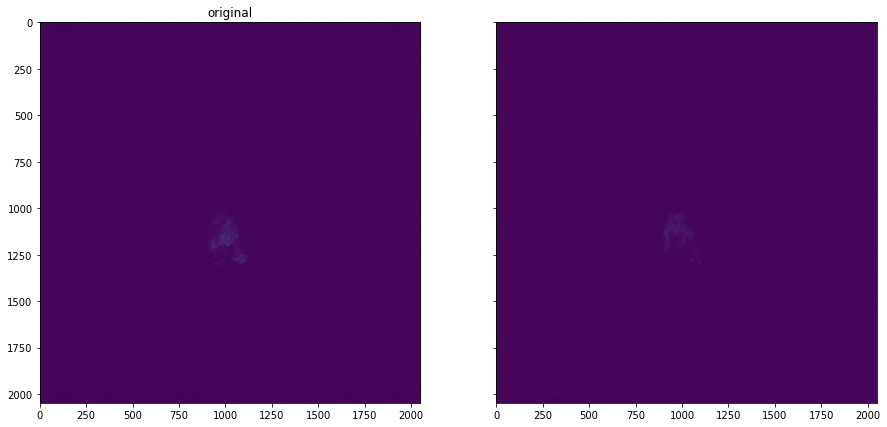

In [7]:
plot_comparison(dataset.get_data(13), dataset.get_data(16), "")

In [8]:
dataset = dataset.reshape_data()

In [9]:
metadata = numpy.swapaxes(dataset.data.metadata, 0, 1)[:, 0].shape

In [10]:
dataset2 = dataset.project_data(1)

In [11]:
dataset2.data.metadata.shape

(2,)

### ROI

In [12]:
from darfix.core import roi

roi_dataset = dataset.apply_roi(origin=[730, 825], size=[726, 346])
# bg_dataset = bg_dataset.apply_roi(origin=[900, 750], size=[500, 500])

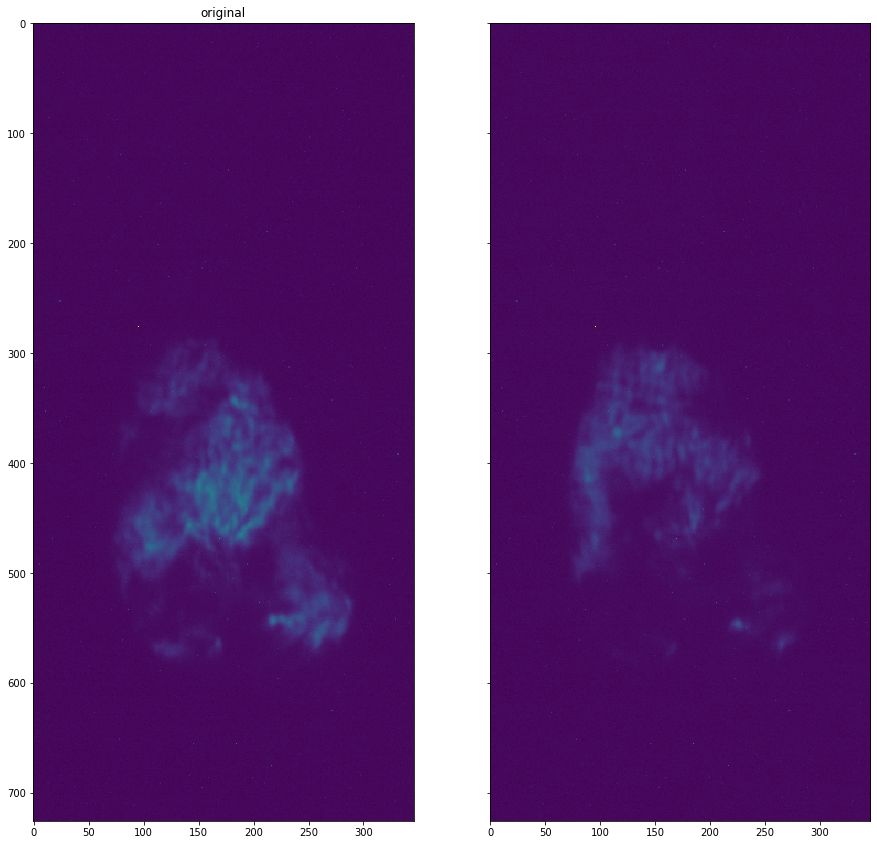

In [13]:
plot_comparison(roi_dataset.get_data(13), roi_dataset.get_data(16), "")

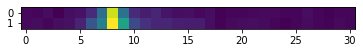

In [14]:
ydata = roi_dataset.data[:, :, 515, 181]
plt.imshow(ydata)

In [32]:
from darfix.core.mapping import fit_2d_rocking_curve

xdim = dataset.dims.get(1)
ydim = dataset.dims.get(0)
y_gauss = fit_2d_rocking_curve([ydata, None], [xdim.unique_values, ydim.unique_values])

In [33]:
def multi_gaussian(M, x0, y0, xalpha, yalpha, A, C):
    x, y = M
    return A * numpy.exp(
        -(((x - x0) / xalpha) ** 2) - ((y - y0) / yalpha) ** 2 + C * (x - x0) * (y - y0)
    )

In [34]:
from scipy.stats import multivariate_normal

xdim = dataset.dims.get(1)
ydim = dataset.dims.get(0)
X, Y = numpy.meshgrid(xdim.unique_values, ydim.unique_values)
xdata = numpy.vstack((X.ravel(), Y.ravel()))
print(xdata.shape)

(2, 961)


In [38]:
from scipy.optimize import curve_fit

A = ydata.ptp()
x0 = numpy.mean(xdim.unique_values)
y0 = numpy.mean(ydim.unique_values)
xalpha = numpy.std(xdim.unique_values)
yalpha = numpy.std(ydim.unique_values)
C = 0
pars, cov = curve_fit(
    f=multi_gaussian,
    xdata=xdata,
    ydata=ydata.ravel(),
    p0=[x0, y0, xalpha, yalpha, A, C],
)
print(pars)
y_gauss = multi_gaussian(xdata, *pars)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

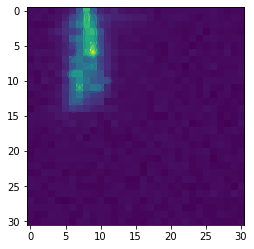

In [37]:
plt.imshow(ydata)
plt.contour(y_gauss.reshape(ydata.shape))
plt.show()

## Filter data

In [11]:
hi_indices, li_indices = dataset.partition_by_intensity()

Computing intensity |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [12]:
li_indices.shape

(397,)

### Background subtraction

In [19]:
dataset = roi_dataset.apply_background_subtraction(method="median")

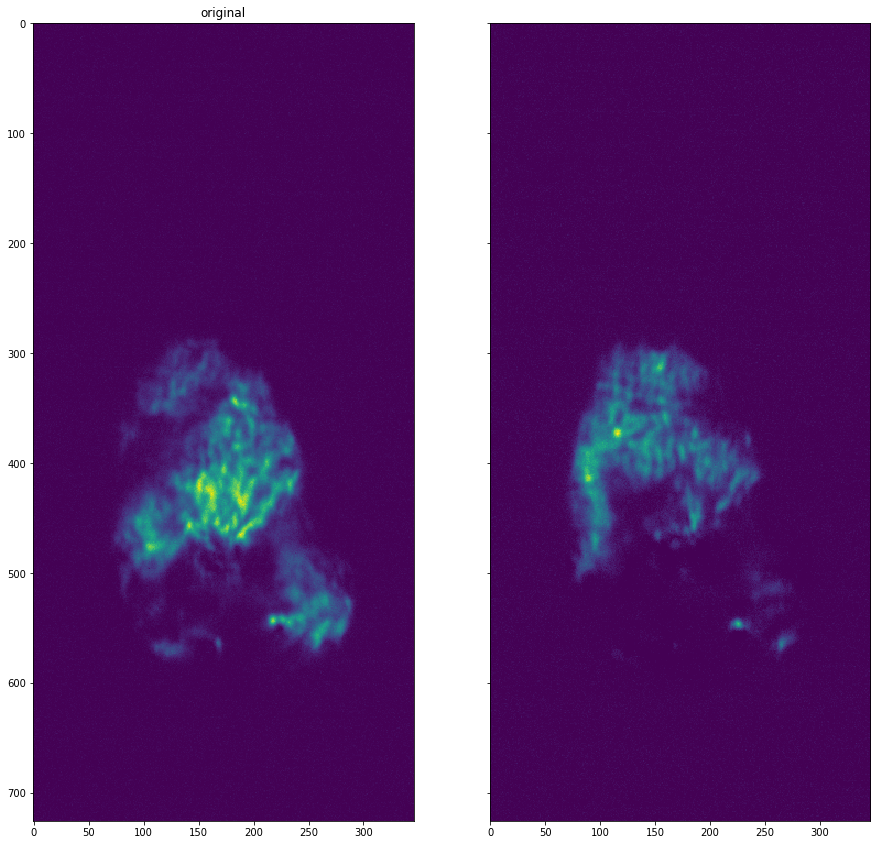

In [20]:
plot_comparison(dataset.get_data(13), dataset.get_data(16), "")

### Hot Pixel Removal

In [21]:
dataset = dataset.apply_hot_pixel_removal()

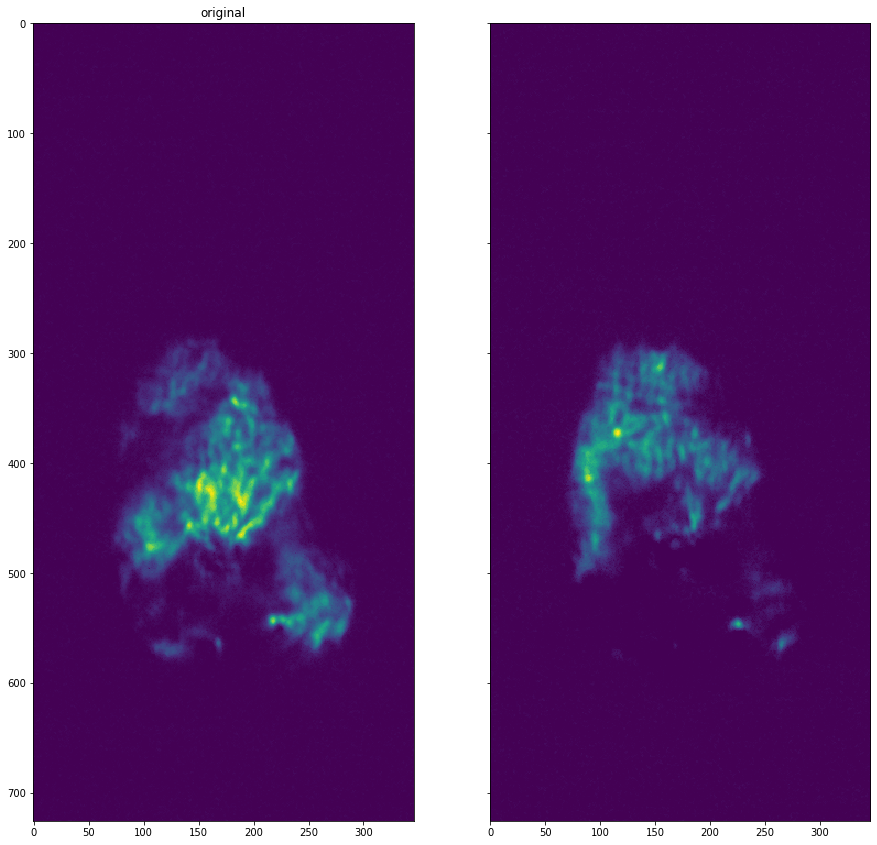

In [22]:
plot_comparison(dataset.get_data(13), dataset.get_data(16), "")

### Threshold removal

In [23]:
dataset = dataset.apply_threshold_removal(bottom=10)

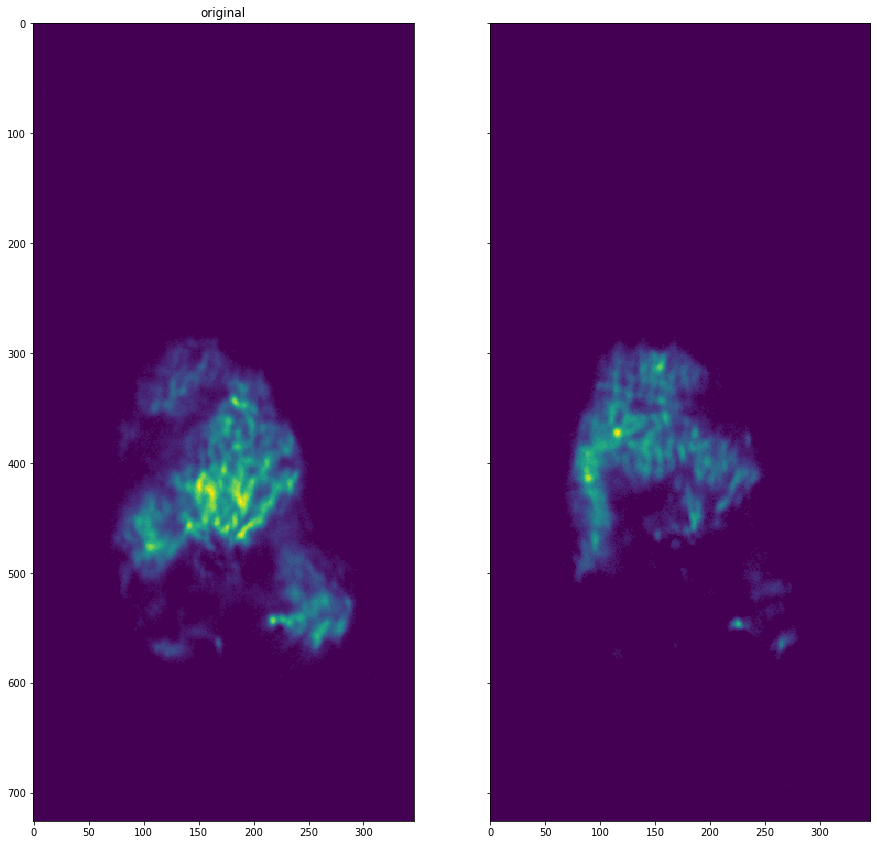

In [24]:
plot_comparison(dataset.get_data(13), dataset.get_data(16), "")

### Shift Detection

In [19]:
shift_dataset = dataset.find_and_apply_shift()

Finding shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Applying shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


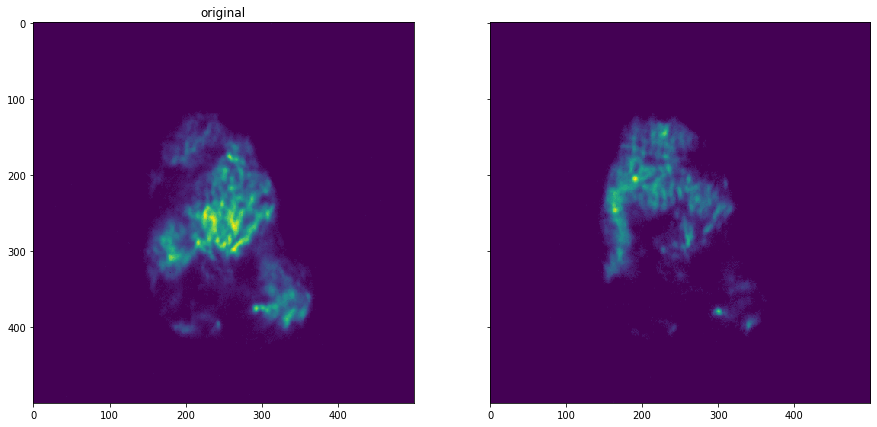

In [20]:
plot_comparison(shift_dataset.get_data(13), shift_dataset.get_data(16), "")

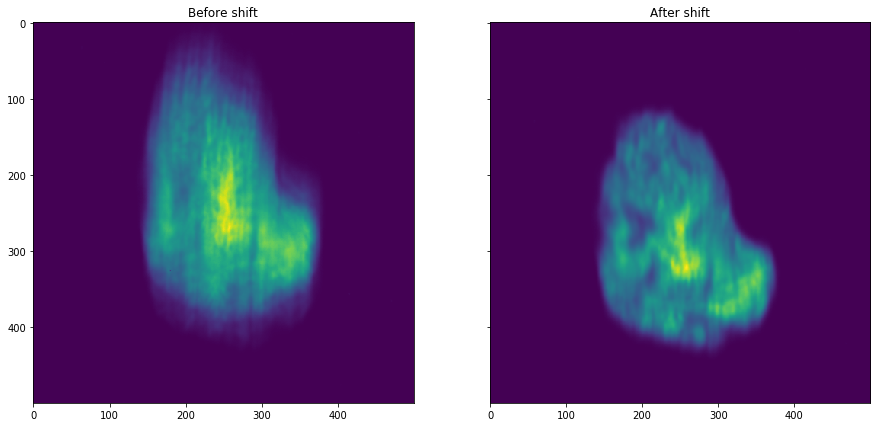

In [21]:
plot_comparison(dataset.zsum(), shift_dataset.zsum(), "After shift", "Before shift")

## BSS

In [92]:
# Find number of components that represent 99% of the data
vals = shift_dataset.pca(return_vals=True)
vals = vals / numpy.sum(vals)
n_components = len(vals[vals > 0.01])
n_components

3

In [93]:
# Compute NNICA+NMF to find the components
comp, W = shift_dataset.nica_nmf(n_components, num_iter=500)

Updating decomposition matrices |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


/users/garrigaf/.local/share/virtualenvs/darfix/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [ ]:
fig, ax = plt.subplots(ncols=n_components, figsize=(50, 5), sharex=True, sharey=True)

# print(components.shape)
plt.suptitle("NNICA components of dataset")
for i in numpy.arange(n_components):
    ax[i].imshow(comp[i].reshape(shift_dataset.get_data(0).shape))
    ax[i].axis("off")

In [ ]:
# Save components on treated folder

from darfix.io.utils import write_components

h, w = shift_dataset.get_data(0).shape
write_components(
    "components",
    "entry",
    shift_dataset.get_dimensions_values(),
    W,
    comp.reshape((n_components, h, w)),
    "1",
)

## Feature Matching

In [ ]:
from darfix.core.componentsMatching import ComponentsMatching, Method
from darfix.io.utils import read_components

db1 = "components"
db2 = "components"


dimensions1, components1, W1 = read_components(db1)
dimensions2, components2, W2 = read_components(db2)

componentsMatching = ComponentsMatching(components=[components1, components2])

final_matches, matches = componentsMatching.match_components(
    method=Method.orb_feature_matching
)

draws = numpy.array(
    componentsMatching.draw_matches(final_matches, matches, displayMatches=False)
)

In [ ]:
rows = 1
cols = int(len(draws) / rows)
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(30, 5))

# print(components.shape)
plt.suptitle("Linked components from two different layers of HEAT 1")
for i in range(cols):
    ax[i].imshow(draws[i], cmap="jet")
    ax[i].axis("off")
    if i in final_matches:
        ax[i].set_title("{}, {}".format(i, final_matches[i]))
    else:
        ax[i].set_title("{}, -".format(i))

## Grain plot

/users/garrigaf/Documents/git/darfix/darfix/core/mapping.py:231: RuntimeWarning: invalid value encountered in true_divide
  com = numpy.sum(stack, axis=0) / zsum
/users/garrigaf/Documents/git/darfix/darfix/core/mapping.py:234: RuntimeWarning: invalid value encountered in true_divide
  std = numpy.sqrt(sum((data[i] * ((repeat_values[i] - com)**2) for i in range(len(data))))) / zsum


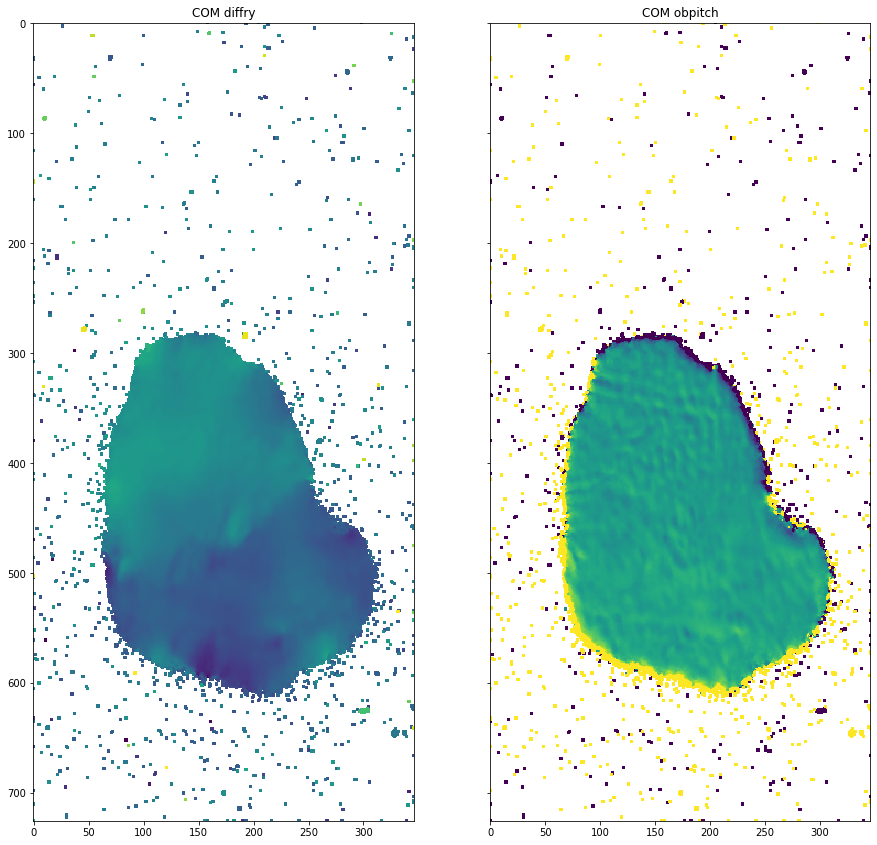

In [25]:
# Compute moments
moments = dataset.apply_moments()
plot_comparison(moments[0][0], moments[1][0], "COM obpitch", "COM diffry")

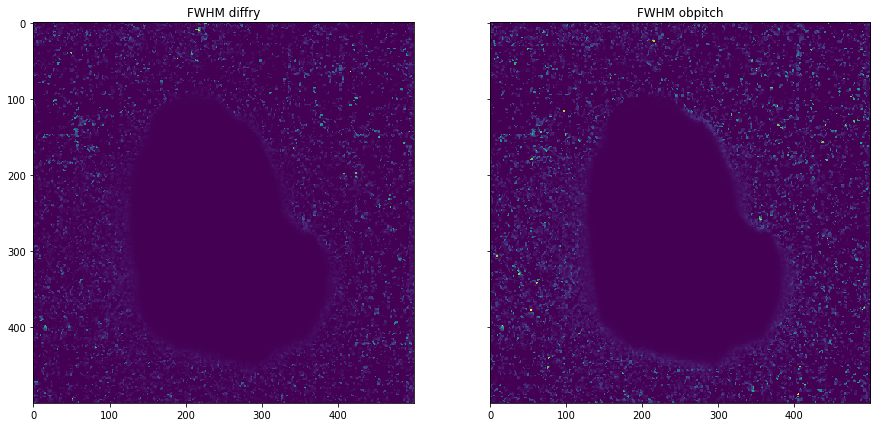

In [49]:
# Compute FWHM
plot_comparison(moments[0][1], moments[1][1], "FWHM obpitch", "FWHM diffry")

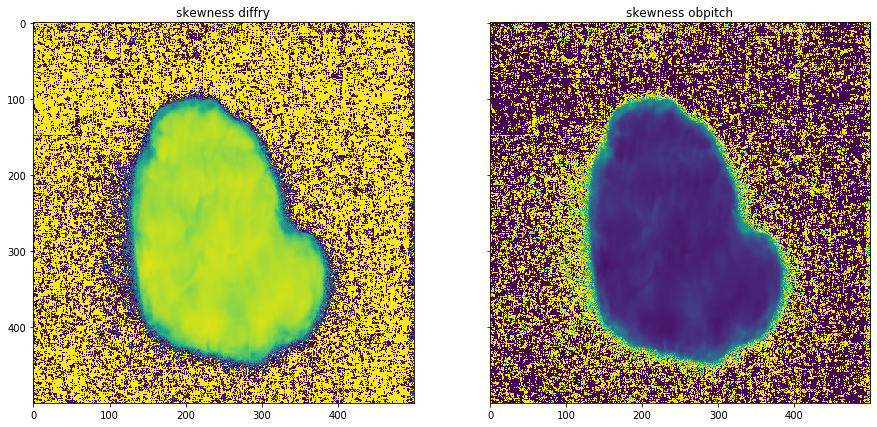

In [50]:
# Show skewness
plot_comparison(moments[0][2], moments[1][2], "skewness obpitch", "skewness diffry")

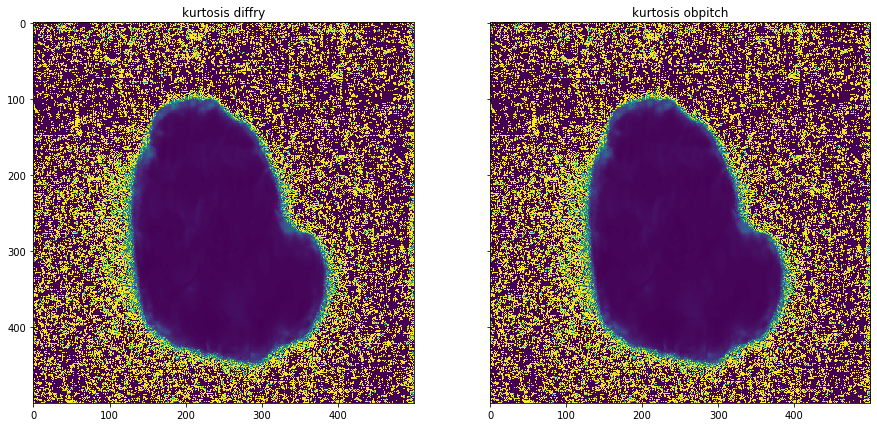

In [51]:
# Compute kurtosis
plot_comparison(moments[0][3], moments[1][3], "kurtosis obpitch", "kurtosis diffry")

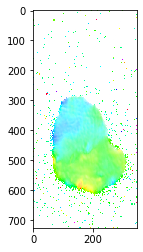

In [45]:
# Compute mosaicity
from matplotlib.colors import hsv_to_rgb

com0 = moments[0][0]
no_nans_indices = ~numpy.isnan(com0)
min_com0 = numpy.min(com0[no_nans_indices] if len(com0[no_nans_indices]) > 0 else com0)
com0[numpy.isnan(com0)] = min_com0
norms0 = (com0 - min_com0) / numpy.ptp(com0)
com1 = moments[1][0]
no_nans_indices = ~numpy.isnan(com1)
min_com1 = numpy.min(com1[no_nans_indices] if len(com1[no_nans_indices]) > 0 else com1)
com1[numpy.isnan(com1)] = min_com1
norms1 = (com1 - min_com1) / numpy.ptp(com1)

mosaicity = numpy.stack((norms0, norms1, numpy.ones(moments[0].shape[1:])), axis=2)

plt.imshow(hsv_to_rgb(mosaicity))

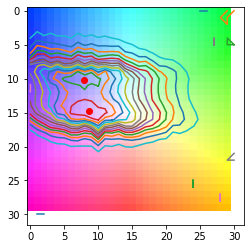

In [91]:
from matplotlib.colors import hsv_to_rgb
from silx.image.marchingsquares import find_contours

ori_dist, hsv_key = shift_dataset.compute_mosaicity_colorkey(scale=1)
plt.imshow(hsv_to_rgb(hsv_key))
levels = numpy.linspace(numpy.min(ori_dist), numpy.max(ori_dist), 15)
for i in levels:
    polygons = find_contours(ori_dist, i)
    for contour in polygons:
        x = contour[:, 1]
        y = contour[:, 0]
        centroid = (sum(x) / len(contour), sum(y) / len(contour))
        plt.plot(x, y)
        if i == levels[-2]:
            plt.plot(centroid[0], centroid[1], "ro")
plt.show()

## Fit data

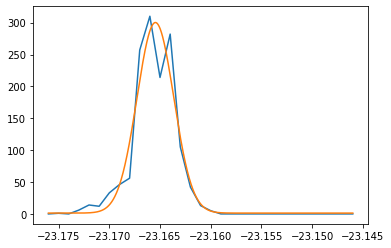

In [50]:
# Show rocking curve
from darfix.core.mapping import fit_rocking_curve

px, py = 300, 374
dimension = [[1], [1]]
data = shift_dataset.get_data(dimension=dimension)

if shift_dataset.in_memory:
    y = data[:, int(py), int(px)]
else:
    y = [image[int(py), int(px)] for image in data]

axis = shift_dataset.dims.ndim - dimension[0][0] - 1
dim = shift_dataset.dims.get(axis)
x = numpy.array(
    [data.metadata[i].get_value(kind=dim.kind, name=dim.name) for i in range(len(data))]
).reshape(-1)
item = [numpy.array(y), None]

plt.plot(x, y)

try:
    y_gauss = fit_rocking_curve(item, values=x, num_points=1000)
except TypeError:
    y_gauss = y
    print("Cannot fit")

x_gauss = numpy.linspace(x[0], x[-1], len(y_gauss))
plt.plot(x_gauss, y_gauss)

In [27]:
%%capture --no-display
fit_dataset = shift_dataset.apply_fit(dimension=dimension)

In [46]:
numpy.max(fit_dataset.zsum()[1])

20.70828701296387

In [47]:
numpy.max(shift_dataset.zsum()[1])

19

In [29]:
img = numpy.sqrt(numpy.subtract(fit_dataset.zsum(), shift_dataset.zsum()) ** 2)

In [43]:
numpy.argmax(numpy.subtract(fit_dataset.zsum(), shift_dataset.zsum())[1])

312

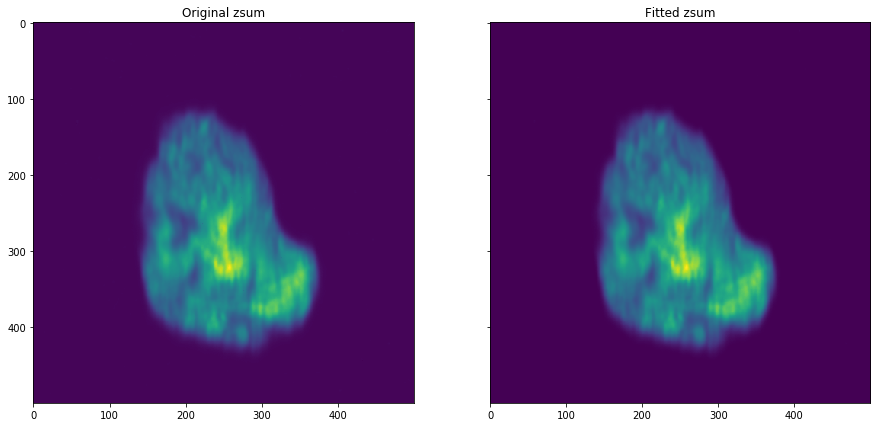

In [31]:
plot_comparison(
    fit_dataset.zsum(), shift_dataset.zsum(), "Fitted zsum", "Original zsum"
)

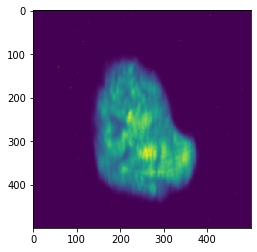

In [62]:
# Plot FWHM

std = numpy.std(shift_dataset.get_data(), axis=0)
std[numpy.isnan(std)] = 0
plt.imshow(2.35482 * std)

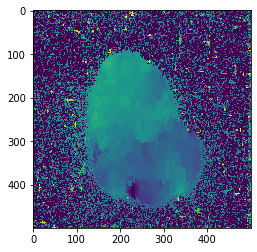

In [63]:
# Plot peak values depending on the dimension (motor choosen for the fit)

data = shift_dataset.get_data()
axis = dimension[0][0]
dim = shift_dataset.dims.get(0)
values = numpy.array(
    [metadata.get_value(kind=dim.kind, name=dim.name)[0] for metadata in data.metadata]
)
x = numpy.array(numpy.argmax(data, axis=0))
image = [values[i] for i in x.flatten()]
image = numpy.reshape(image, x.shape)

plt.imshow(image)